In [9]:
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import nltk
import glob
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten
import re
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
%matplotlib inline

def token_to_pos(ch):
    tokens = nltk.word_tokenize(ch)
    return [p[1] for p in nltk.pos_tag(tokens)]
    

def corpustovector(corpus):
        # create feature vectors
    num_tweets = len(corpus)
    fvs_lexical = np.zeros((len(corpus), 3), np.float64)
    fvs_punct = np.zeros((len(corpus), 3), np.float64)



    for e, tw_text in enumerate(corpus):
        # note: the nltk.word_tokenize includes punctuation
        tokens = nltk.word_tokenize(tw_text.lower())
        words = word_tokenizer.tokenize(tw_text.lower())
        sentences = sentence_tokenizer.tokenize(tw_text)
        vocab = set(words)
        words_per_sentence = np.array([len(word_tokenizer.tokenize(s)) for s in sentences])

        # average number of words per sentence
        fvs_lexical[e, 0] = words_per_sentence.mean()
        # sentence length variation
        fvs_lexical[e, 1] = words_per_sentence.std()
        # Lexical diversity
        fvs_lexical[e, 2] = len(vocab) / float(len(words))

        # Commas per sentence
        fvs_punct[e, 0] = tokens.count(',') / float(len(sentences))
        # Exclamations per sentence
        fvs_punct[e, 1] = tokens.count('!') / float(len(sentences))
        # Colons per sentence
        fvs_punct[e, 2] = tokens.count(':') / float(len(sentences))     
        
 
    # apply whitening to decorrelate the features
    fvs_lexical = whiten(fvs_lexical)
    fvs_punct = whiten(fvs_punct)
    
    # get most common words in the whole book
    NUM_TOP_WORDS = 10
    
    translator = str.maketrans('', '', string.punctuation)

    all_text = ' '.join(corpus)
    all_tokens = nltk.word_tokenize(all_text.translate(translator))
    fdist = nltk.FreqDist(all_tokens)
    vocab = sorted(fdist, key=fdist.get, reverse=True)[:NUM_TOP_WORDS]

    # use sklearn to create the bag for words feature vector for each speech
    vectorizer = CountVectorizer(vocabulary=vocab, tokenizer=nltk.word_tokenize)
    fvs_bow = vectorizer.fit_transform(corpus).toarray().astype(np.float64)

    # normalise by dividing each row by its Euclidean norm
    fvs_bow /= np.c_[np.apply_along_axis(np.linalg.norm, 1, fvs_bow)]
    fvs_bow = np.nan_to_num(fvs_bow)
    
    
    tweets_pos = [token_to_pos(tw) for tw in corpus]
 
    # count frequencies for common POS types
    pos_list = ['NN', 'NNP', 'DT', 'IN', 'JJ', 'NNS']
    fvs_syntax = np.array([[tw.count(pos) for pos in pos_list]
                           for tw in tweets_pos]).astype(np.float64)


    # normalise by dividing each row by number of tokens in the chapter
    fvs_syntax /= np.c_[np.array([len(tw) for tw in tweets_pos])]
    
    
    fvs = np.c_[fvs_lexical , fvs_punct , fvs_bow, fvs_syntax]
    cols=['mean-wps', 'std-wps', 'div-wps', 'commas','ats','colons','bow1','bow2','bow3','bow4','bow5','bow6','bow7','bow8','bow9','bow10','NN', 'NNP', 'DT', 'IN', 'JJ', 'NNS']
    dfCorpus = pd.DataFrame(fvs, columns=cols)
    print(dfCorpus.shape)
    return dfCorpus

In [2]:
nltk.data.path.append('N:\\nltk_data')
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
word_tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

def concat_tweets(tweets, n):
    concatenated = []
    for i in range(len(tweets) // n):
        appendable = ''
        for x in range(n):
            appendable += (tweets[i + x*n] + ' ')
        concatenated.append(str(appendable)) 
    return concatenated

# Load data
folder = './Campaign Speeches/2016/nltk'
folder2 ='./Twitter/tweets/nltk/'
tweets=[]
labels = []
row_labels = []
for e, file in enumerate(os.listdir(folder)):
    with open(os.path.join(folder, file)) as f:
        newTweets = f.read().split('\n')
        newTweets.pop()
        newTweetsConcat = concat_tweets(newTweets, 1)
        print('Number of Tweets for', \
              file.strip('.txt'), ':', len(newTweetsConcat))
        tweets=tweets+newTweetsConcat
        labels.append(file.strip('.txt'))
        for i in range(len(newTweetsConcat)):
            row_labels.append(e)

dfFeatures = corpustovector(tweets)
df = pd.DataFrame()
df['tweets'] = tweets
df['label'] = row_labels

Number of Tweets for Bernie-Sanders : 29
Number of Tweets for Donald-Trump : 74
(103, 22)


Train several machine learning classifiers on the tweet data

In [3]:
X = dfFeatures
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33)

names= ['kNN', 'Decision Tree', 'Random Forest', 'MLP', 'AdaBoost', 'Gaussian']

#Defines each classifier and puts them in an array
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(n_estimators = 20, algorithm='SAMME'),
    GaussianNB()]

allScores=[]
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    scores =  clf.score(X_test, y_test)
    print(clf)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    allScores.append(scores.mean())
    print()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
Accuracy: 0.85 (+/- 0.00)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.97 (+/- 0.00)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy: 0.88 (+/- 0.00)

MLPClassifier(activation='relu', alpha=1, batch_size='auto', be

Use PCA to reduce the feature vector to 2 dimensions, train the machine learning classifiers on the result, and graph the visualization of each classifier in 2d space

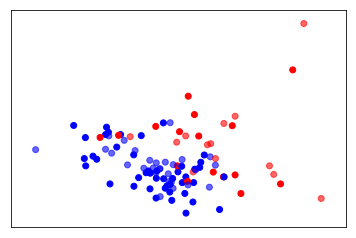

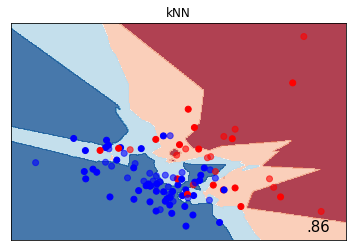

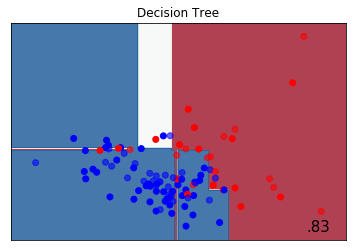

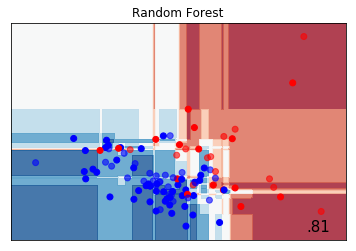

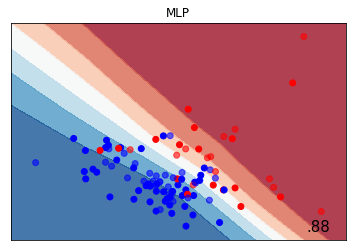

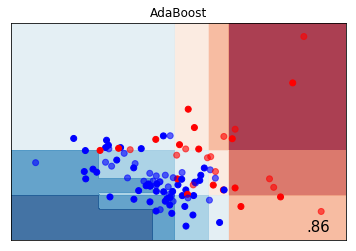

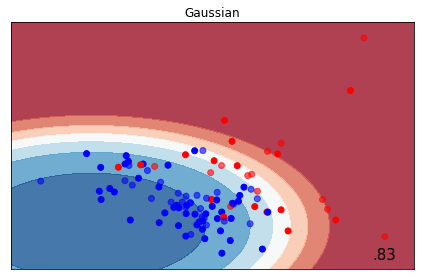

In [4]:
pca = PCA(n_components=2, svd_solver='full')
pca.fit(X)
pcavecs = pca.transform(X)

#figure = plt.figure()
i = 1
# iterate over datasets
h=.02
# preprocess dataset, split into training and test part
X = pcavecs
y = df['label']
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)
 
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
 
# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = matplotlib.colors.ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot()
 
# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
# and testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i += 1
 
# iterate over classifiers
for name, clf in zip(names, classifiers):
    plt.figure()
    ax = plt.subplot()
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

 
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])            
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
 
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
 
 
    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               alpha=0.6)
 
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    plt.title(name)
 
plt.tight_layout()
#plt.show()

In [5]:
def predict_politician_per_classifer(features, labels, classifer):
    lexical = ['mean-wps', 'std-wps', 'div-wps']
    punc = ['commas', 'ats', 'colons']
    bow = ['bow1','bow2','bow3','bow4','bow5','bow6','bow7','bow8','bow9','bow10']
    syntactic = ['NN', 'NNP', 'DT', 'IN', 'JJ', 'NNS']

    feature_sets = [lexical, punc, bow, syntactic]
    feature_set_names = ['Lexical', 'Punctuation', 'Bag of Words', 'Syntactic']
    
    accuracies = ''
    
    for feature_set, name in zip(feature_sets, feature_set_names):
        X_train, X_test, y_train, y_test = \
            train_test_split(features[feature_set], labels, test_size=.4)
        clf = classifer
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        score_str = "%0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2)
        accuracy_str = str(name + ': ' + score_str)
        accuracies += (accuracy_str + '\n')
    
    return accuracies

In [6]:
names= ['kNN', 'Decision Tree', 'Random Forest', 'MLP', 'AdaBoost', 'Gaussian']

#Defines each classifier and puts them in an array
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(n_estimators = 20, algorithm='SAMME'),
    GaussianNB()]

for clf, name in zip(classifiers, names):
    print(name, str(':\n'+ predict_politician_per_classifer(dfFeatures, row_labels, clf)))

kNN :
Lexical: 0.88 (+/- 0.00)
Punctuation: 0.76 (+/- 0.00)
Bag of Words: 0.88 (+/- 0.00)
Syntactic: 0.83 (+/- 0.00)

Decision Tree :
Lexical: 0.79 (+/- 0.00)
Punctuation: 0.76 (+/- 0.00)
Bag of Words: 0.93 (+/- 0.00)
Syntactic: 0.86 (+/- 0.00)

Random Forest :
Lexical: 0.79 (+/- 0.00)
Punctuation: 0.67 (+/- 0.00)
Bag of Words: 0.86 (+/- 0.00)
Syntactic: 0.93 (+/- 0.00)

MLP :
Lexical: 0.86 (+/- 0.00)
Punctuation: 0.81 (+/- 0.00)
Bag of Words: 0.79 (+/- 0.00)
Syntactic: 0.64 (+/- 0.00)

AdaBoost :
Lexical: 0.86 (+/- 0.00)
Punctuation: 0.83 (+/- 0.00)
Bag of Words: 0.88 (+/- 0.00)
Syntactic: 0.83 (+/- 0.00)

Gaussian :
Lexical: 0.76 (+/- 0.00)
Punctuation: 0.79 (+/- 0.00)
Bag of Words: 0.86 (+/- 0.00)
Syntactic: 0.93 (+/- 0.00)



Now time to build the classifier for campaign speeches!

In [7]:
root='./Campaign Speeches/2016/nltk/'
candidates=os.listdir(root)
tweets=[]
labels = []
y=[]
for e, file in enumerate(os.listdir(root)):
    with open(os.path.join(root, file)) as f:
        newTweets = f.read().split('\n')
        newTweets.pop()
        tweets=tweets+newTweets
        for i in range(len(newTweets)):
            labels.append(file.strip('.txt'))
            y.append(e)
        
all_text = ' '.join(tweets)

dfFeatures = corpustovector(tweets)
df=pd.DataFrame()
df['tweets']=tweets
df['label']=y




(103, 22)


In [10]:
X = dfFeatures
y = df['label']


names= ['kNN', 'Decision Tree', 'Random Forest', 'MLP', 'AdaBoost', 'gaus']

#Defines each classifier and puts them in an array
classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(warm_start=True, n_jobs=-1, n_estimators =20, max_depth=19,  max_features=None, criterion='entropy'),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(n_estimators = 20, algorithm='SAMME'),
    GaussianNB()]


allScores=[]
# iterate over classifiers
for name, clf in zip(names,
                     classifiers):
    scores =  cross_val_score(clf, X, y, cv=5)
    print(clf)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    allScores.append(scores.mean())
    print()



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')
Accuracy: 0.79 (+/- 0.16)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
Accuracy: 0.86 (+/- 0.32)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=19, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=True)
Accuracy: 0.88 (+/- 0.24)

MLPClassifier(activation='relu', alpha=1, batch_size='auto', bet

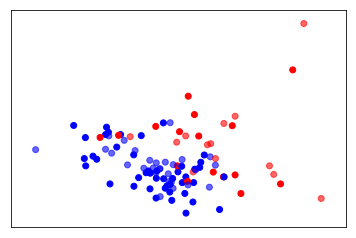

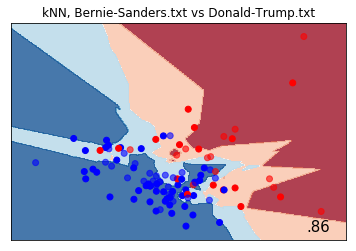

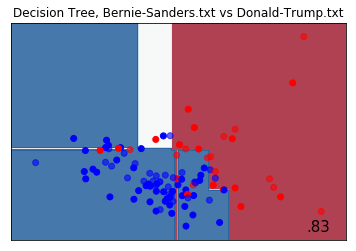

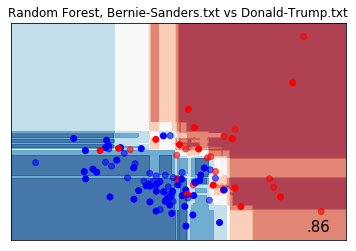

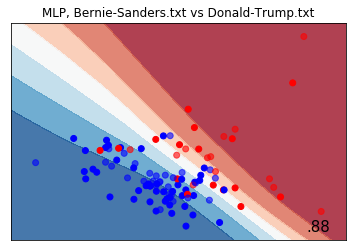

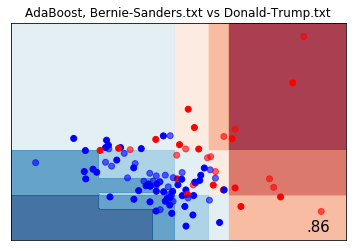

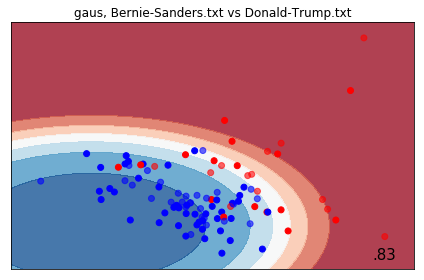

In [11]:
pca = PCA(n_components=2, svd_solver='full')
pca.fit(dfFeatures)
pcavecs = pca.transform(dfFeatures)
#print(pcavecs)


i = 1
# iterate over datasets
h=.02
# preprocess dataset, split into training and test part
X = pcavecs
y = df['label']
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = matplotlib.colors.ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot()

# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
# and testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i += 1

# iterate over classifiers
for name, clf in zip(names, classifiers):
    plt.figure()
    ax = plt.subplot()
    #ax.set_title(name+' '+sub+', '+' vs '.join(candidates))
    ax.set_title(name+', '+' vs '.join(candidates))
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])            
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)


    # Plot also the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
               alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
            size=15, horizontalalignment='right')
    i += 1

plt.tight_layout()